---
title: Fitting a Multivariate Normal Model in PyMC3 with an LKJ Prior
tags: Bayesian Statistics, PyMC3
---

Outside of the [beta](https://en.wikipedia.org/wiki/Beta_distribution)-[binomial](https://en.wikipedia.org/wiki/Binomial_distribution) model, the multivariate normal model is likely the most studied Bayesian model in history.  Unfortunately, as this [issue](https://github.com/pymc-devs/pymc3/issues/538) shows, `pymc3` cannot (yet) sample from the standard conjugate [normal-Wishart](https://en.wikipedia.org/wiki/Normal-Wishart_distribution) model.  Fortunately, `pymc3` *does* support sampling from the [LKJ distribution](http://www.sciencedirect.com/science/article/pii/S0047259X09000876).  This post will show how to fit a simple multivariate normal model using `pymc3` with an normal-LKJ prior.

The normal-Wishart prior is conjugate for the multivariate normal model, so we can find the posterior distribution in closed form.  Even with this closed form solution, sampling from a multivariate normal model in `pymc3` is important as a building block for more complex models that will be discussed in future posts.

First, we generate some two-dimensional sample data.

In [1]:
%matplotlib inline

In [2]:
from matplotlib.patches import Ellipse
from matplotlib import pyplot as plt
import numpy as np
import pymc3 as pm
import scipy as sp
import seaborn as sns
from theano import tensor as T

In [3]:
np.random.seed(3264602) # from random.org

In [4]:
N = 100

mu_actual = sp.stats.uniform.rvs(-5, 10, size=2)

cov_actual_sqrt = sp.stats.uniform.rvs(0, 2, size=(2, 2))
cov_actual = np.dot(cov_actual_sqrt.T, cov_actual_sqrt)

x = sp.stats.multivariate_normal.rvs(mu_actual, cov_actual, size=N)

In [5]:
var, U = np.linalg.eig(cov_actual)
angle = 180. / np.pi * np.arccos(np.abs(U[0, 0]))

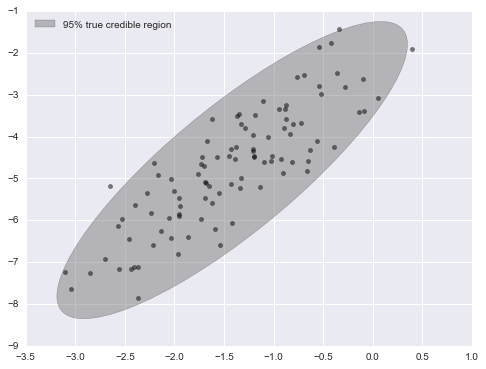

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))

blue = sns.color_palette()[0]

e = Ellipse(mu_actual, 2 * np.sqrt(5.991 * var[0]), 2 * np.sqrt(5.991 * var[1]), angle=-angle)
e.set_alpha(0.5)
e.set_facecolor('gray')
e.set_zorder(10);
ax.add_artist(e);

ax.scatter(x[:, 0], x[:, 1], c='k', alpha=0.5, zorder=11);

rect = plt.Rectangle((0, 0), 1, 1, fc='gray', alpha=0.5)
ax.legend([rect], ['95% true credible region'], loc=2);

The sampling distribution for our model is $x_i \sim N(\mu, \Lambda)$, where $\Lambda$ is the [precision matrix](https://en.wikipedia.org/wiki/Precision_(statistics)) of the distribution.  The precision matrix is the inverse of the covariance matrix.  The support of the LKJ distribution is the set of [correlation matrices](https://en.wikipedia.org/wiki/Correlation_and_dependence#Correlation_matrices), not covariance matrices.  We will use the separation strategy from [Barnard et al.](http://www3.stat.sinica.edu.tw/statistica/oldpdf/A10n416.pdf) to combine an LKJ prior on the correlation matrix with a prior on the standard deviations of each dimension to produce a prior on the covariance matrix.

Let $\sigma$ be the vector of standard deviations of each component of our normal distribution, and $\mathbf{C}$ be the correlation matrix.   The relationship

$$\Sigma = \operatorname{diag}(\sigma)\ \mathbf{C} \operatorname{diag}(\sigma)$$

shows that priors on $\sigma$ and $\mathbf{C}$ will induce a prior on $\Sigma$.  Following Barnard et al., we place a standard [lognormal](https://en.wikipedia.org/wiki/Log-normal_distribution) prior each the elements $\sigma$, and an LKJ prior on the correlation matric $\mathbf{C}$.  The LKJ distribution requires a shape parameter $\nu > 0$.  If $\mathbf{C} \sim LKJ(\nu)$, then $f(\mathbf{C}) \propto |\mathbf{C}|^{\nu - 1}$ (here $|\cdot|$ is the determinant).

We can now begin to build this model in `pymc3`.

In [7]:
with pm.Model() as model:
    sigma = pm.Lognormal('sigma', np.zeros(2), np.ones(2), shape=2)
    
    nu = pm.Uniform('nu', 0, 5)
    C_triu = pm.LKJCorr('C_triu', nu, 2) 

There is a slight complication in `pymc3`'s handling of the `LKJCorr` distribution; `pymc3` represents the support of this distribution as a one-dimensional vector of the upper triangular elements of the full covariance matrix. 

In [8]:
C_triu.tag.test_value.shape

(1,)

In order to build a the full correlation matric $\mathbf{C}$, we first build a $2 \times 2$ tensor whose values are all `C_triu` and then set the diagonal entries to one.  (Recall that a correlation matrix must be symmetric and positive definite with all diagonal entries equal to one.)  We can then proceed to build the covariance matrix $\Sigma$ and the precision matrix $\Lambda$.

In [9]:
with model:
    C = pm.Deterministic('C', T.fill_diagonal(C_triu[np.zeros((2, 2), dtype=np.int64)], 1.))
    
    sigma_diag = pm.Deterministic('sigma_mat', T.nlinalg.diag(sigma))
    cov = pm.Deterministic('cov', T.nlinalg.matrix_dot(sigma_diag, C, sigma_diag))
    tau = pm.Deterministic('tau', T.nlinalg.matrix_inverse(cov))

While defining `C` in terms of `C_triu` was simple in this case because our sampling distribution is two-dimensional, the example from this [StackOverflow question](http://stackoverflow.com/questions/29759789/modified-bpmf-in-pymc3-using-lkjcorr-priors-positivedefiniteerror-using-nuts) shows how to generalize this transformation to arbitrarily many dimensions.

Finally, we define the prior on $\mu$ and the sampling distribution.

In [10]:
with model:
    mu = pm.MvNormal('mu', 0, tau, shape=2)
    
    x_ = pm.MvNormal('x', mu, tau, observed=x)

We are now ready to fit this model using `pymc3`.

In [11]:
n_samples = 4000
n_burn = 2000
n_thin = 2

In [12]:
with model:
    step = pm.Metropolis()
    trace_ = pm.sample(n_samples, step)

100%|██████████| 4000/4000 [00:04<00:00, 957.53it/s] 


In [13]:
trace = trace_[n_burn::n_thin]

We see that the posterior estimate of $\mu$ is reasonably accurate.

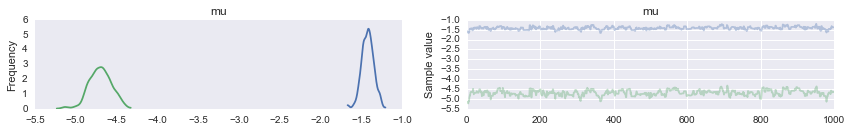

In [15]:
pm.traceplot(trace, varnames=['mu']);

In [16]:
trace['mu'].mean(axis=0)

array([-1.42193985, -4.69764027])

In [17]:
mu_actual

array([-1.41866859, -4.8018335 ])

The estimates of the standard deviations are certainly biased.

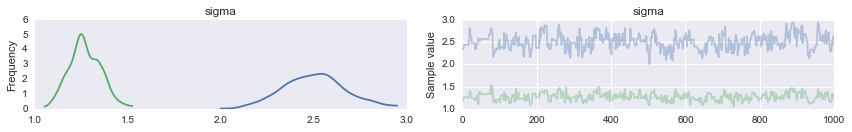

In [18]:
pm.traceplot(trace, varnames=['sigma']);

In [19]:
trace['sigma'].mean(axis=0)

array([ 2.50325408,  1.26997012])

In [20]:
np.sqrt(var)

array([ 0.3522422 ,  1.58192855])

However, the 95% posterior credible region is visuall quite close to the true credible region, so we can be fairly satisfied with our model.

In [21]:
post_cov = trace['cov'].mean(axis=0)

post_sigma, post_U = np.linalg.eig(post_cov)
post_angle = 180. / np.pi * np.arccos(np.abs(post_U[0, 0]))

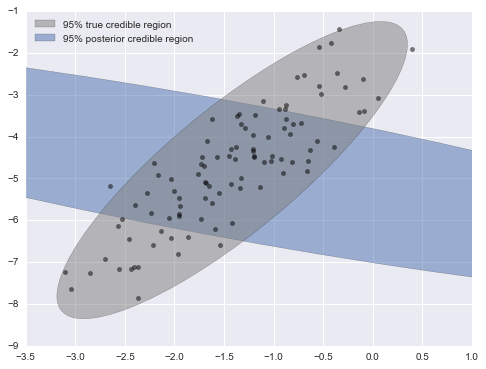

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))

blue = sns.color_palette()[0]

e = Ellipse(mu_actual, 2 * np.sqrt(5.991 * post_sigma[0]), 2 * np.sqrt(5.991 * post_sigma[1]), angle=-post_angle)
e.set_alpha(0.5)
e.set_facecolor(blue)
e.set_zorder(9);
ax.add_artist(e);

e = Ellipse(mu_actual, 2 * np.sqrt(5.991 * var[0]), 2 * np.sqrt(5.991 * var[1]), angle=-angle)
e.set_alpha(0.5)
e.set_facecolor('gray')
e.set_zorder(10);
ax.add_artist(e);

ax.scatter(x[:, 0], x[:, 1], c='k', alpha=0.5, zorder=11);

rect = plt.Rectangle((0, 0), 1, 1, fc='gray', alpha=0.5)
post_rect = plt.Rectangle((0, 0), 1, 1, fc=blue, alpha=0.5)
ax.legend([rect, post_rect],
          ['95% true credible region',
           '95% posterior credible region'],
          loc=2);

Again, this model is quite simple, but will be an important component of more complex models that I will blog about in the future.

This post is available as an [IPython](http://ipython.org/) notebook [here](https://gist.github.com/AustinRochford/fa24221f09df20071c06).